In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import files from data wrangling step

In [131]:
from google.colab import files

ratings = pd.read_csv('cleaned_game_ratings.csv', index_col=0)
reviews = pd.read_csv('cleaned_game_reviews.csv', index_col=0)

comments_only = reviews['comment']

Take a sample to make word tokenizing possible because of the huge data set



In [132]:
np.random.seed(42)
N = 100_000

# I tried the code sample you had, but it gave me a missing index error. And this seemed to give the same output I think you
# were creating - a list of 10_000 comments
comment_sample = np.random.choice(comments_only, size=N, replace=False)

Convert the list to strings for nltk

In [133]:
comments = ''
for _ in comment_sample:
  comments += _

'The movie in a box....awesome sauce!Love the mechanics. The Lovecraft theme is not really relevant... could be any kind of monsters.  The semi-coop works well, especially with 3 or 4 players. Did not try the solo version, but the variant for a 2 players game is great! Would suggest to play with 2 or 3 players. 4 players is still nice but can add a lot of playing time....like, a lot!!  Very Good game in general!Un juego muy versátil que ha gustado en todos los grupos con los que ha visto mesa.  Un modo de fiesta muy divertido para jugar con grupos grandes, y un modo estratégico que convence a j'

Remove non-English words - skipping this step for now

In [134]:
# words = set(nltk.corpus.words.words())

# # Need to revisit this? It does get some out, but also removes words like Lovecraft, monsters, etc
# comments = " ".join(w for w in nltk.wordpunct_tokenize(comments) if w.lower() in words or not w.isalpha())

'The movie in a box .... awesome sauce ! Love the mechanics . The theme is not really relevant ... could be any kind of . The semi - coop works well , especially with 3 or 4 . Did not try the solo version , but the variant for a 2 game is great ! Would suggest to play with 2 or 3 . 4 is still nice but can add a lot of time .... like , a lot !! Very Good game in general ! Un ha en con ha visto mesa '

Tokenize using nltk

In [135]:
comment_tokens = [nltk.word_tokenize(_) for _ in nltk.sent_tokenize(comments)]

[['The', 'movie', 'in', 'a', 'box', '...', '.', 'awesome', 'sauce', '!'],
 ['Love', 'the', 'mechanics', '.'],
 ['The',
  'theme',
  'is',
  'not',
  'really',
  'relevant',
  '...',
  'could',
  'be',
  'any',
  'kind',
  'of',
  '.'],
 ['The',
  'semi',
  '-',
  'coop',
  'works',
  'well',
  ',',
  'especially',
  'with',
  '3',
  'or',
  '4',
  '.'],
 ['Did',
  'not',
  'try',
  'the',
  'solo',
  'version',
  ',',
  'but',
  'the',
  'variant',
  'for',
  'a',
  '2',
  'game',
  'is',
  'great',
  '!'],
 ['Would', 'suggest', 'to', 'play', 'with', '2', 'or', '3', '.'],
 ['4',
  'is',
  'still',
  'nice',
  'but',
  'can',
  'add',
  'a',
  'lot',
  'of',
  'time',
  '...',
  '.',
  'like',
  ',',
  'a',
  'lot',
  '!',
  '!'],
 ['Very', 'Good', 'game', 'in', 'general', '!'],
 ['Un', 'ha', 'en', 'con', 'ha', 'visto', 'mesa', '.'],
 ['Un', 'de', 'fiesta', 'para', 'con', ',', 'y', 'un', 'a', '.']]

Remove punctuation

In [136]:
comment_text = nltk.Text(comment_tokens)

comment_no_punc = [word.lower() for sent in comment_text for word in sent if word.isalpha()]
comment_no_punc[:10]

['the',
 'movie',
 'in',
 'a',
 'box',
 'awesome',
 'sauce',
 'love',
 'the',
 'mechanics']

Remove stop words

In [137]:
stop_words = set(stopwords.words('english'))

comments_no_stops = [word for word in comment_no_punc if word.casefold() not in stop_words]

['movie',
 'box',
 'awesome',
 'sauce',
 'love',
 'mechanics',
 'theme',
 'really',
 'relevant',
 'could',
 'kind',
 'semi',
 'coop',
 'works',
 'well',
 'especially',
 'try',
 'solo',
 'version',
 'variant']

Make all words lowercase

In [138]:
comment_no_stops_lower = [word.lower() for word in comments_no_stops]
comment_unique_words = sorted(set(comment_no_stops_lower))

['aa',
 'aam',
 'aback',
 'abacus',
 'abalone',
 'abandon',
 'abandoned',
 'abate',
 'abbey',
 'abbot',
 'abbreviate',
 'abduct',
 'abductor',
 'aberrant',
 'aberration',
 'abhor',
 'abhorrent',
 'abide',
 'abiding',
 'abigail']

Create lexical diversity function to look for the richness of the vocabulary

In [139]:
def lexical_diversity(text):
  return len(text) / len(set(text))

Calculate lexical diversity

In [155]:
print("Lexical diversity is:", lexical_diversity(comment_no_stops_lower))

Lexical diversity is: 93.3926526202053


Frequency distribution plots

In [141]:
comment_dist = nltk.FreqDist(comment_no_stops_lower)

comment_vocabulary = comment_dist.keys()

Plot top 50 words

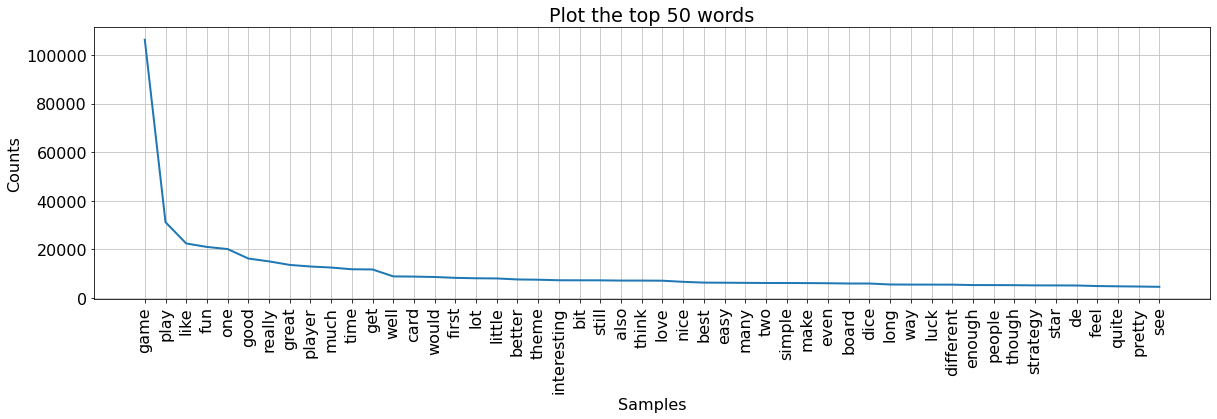

In [164]:
plt.figure(figsize=(20,5))
plt.xticks(rotation = 40) # this is the same chunk of code that worked fine elsewhere and examples across the net - no idea why it's not working
plt.rc('font', size=16)
plt.title('Plot the top 50 words')
comment_dist.plot(50, cumulative=False)
comment_hapaxes = comment_dist.hapaxes()

Find long words

In [165]:
long_words = [_ for _ in comment_dist if len(_) > 10]
long_words[:10]

['unfortunately',
 'overwhelming',
 'disappointing',
 'interesting',
 'implementation',
 'counterpart',
 'interaction',
 'improvement',
 'established',
 'alternatively']

Plot top 50 long words

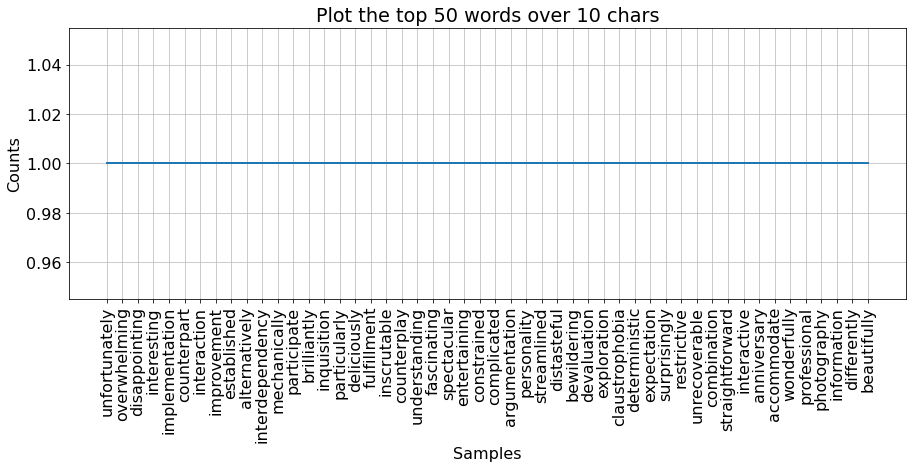

In [167]:
long_word_dist = nltk.FreqDist(long_words)

plt.figure(figsize=(15,5))
plt.rc('font', size=16)
plt.xticks(rotation=50)
plt.title('Plot the top 50 words over 10 chars')
long_word_dist.plot(50, cumulative=False)
long_word_hapaxes = long_word_dist.hapaxes()

Word length distribution

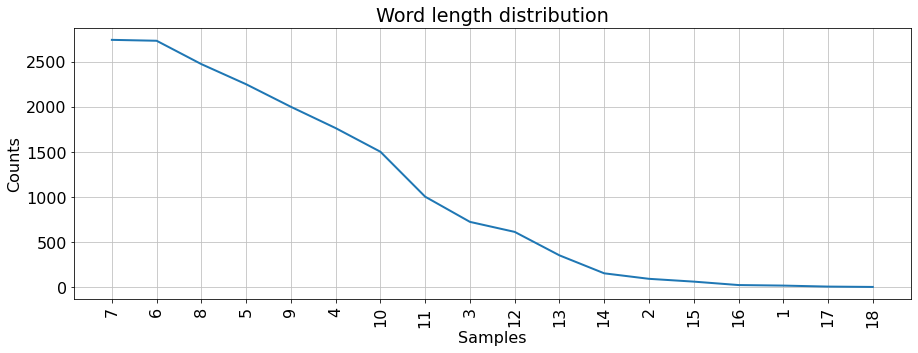

In [168]:
plt.figure(figsize=(15,5))
plt.rc('font', size=16)
plt.title("Word length distribution")

comment_word_length = nltk.FreqDist([len(word) for word in comment_dist])
comment_word_length.plot(200, cumulative=False)

Build a word cloud

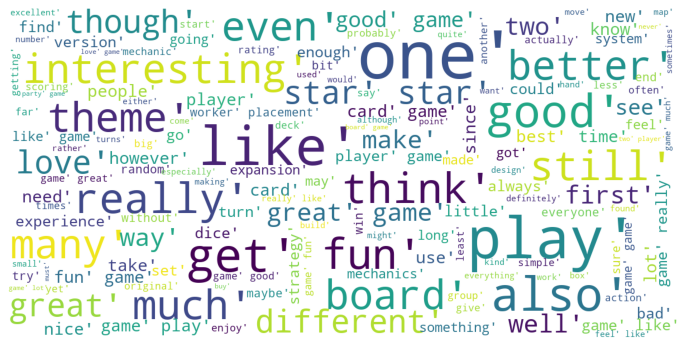

In [169]:
def show_wordcloud(data):
  wordcloud = WordCloud(
      background_color="white",
      max_words=150,
      max_font_size=40,
      scale=3,
      random_state=1
  )

  wordcloud = wordcloud.generate(str(data))

  fig = plt.figure(1, figsize=(12, 12))
  plt.axis('off')
  plt.imshow(wordcloud)
  plt.show()

show_wordcloud(comment_no_stops_lower)

Plot top 50 bigrams

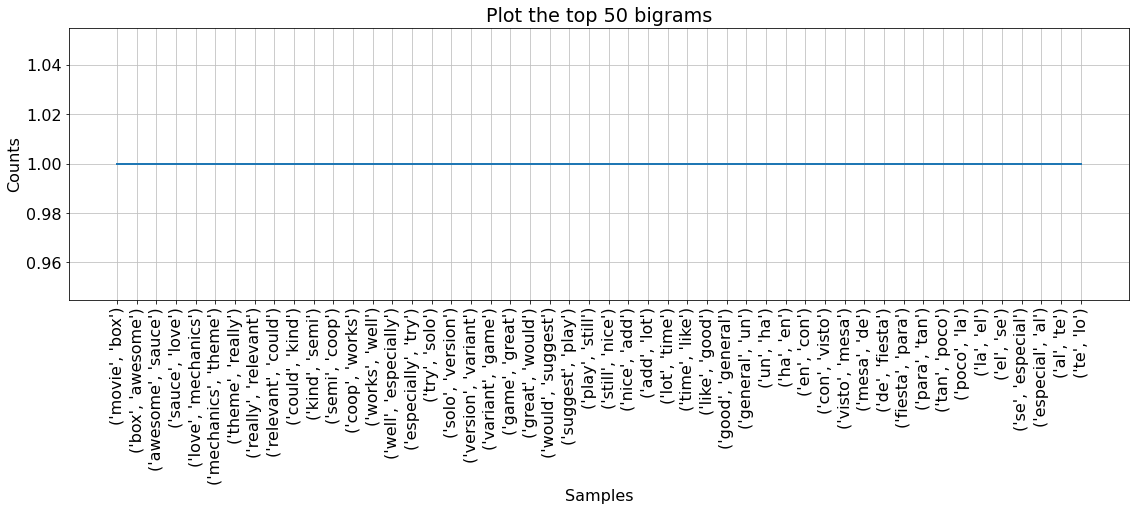

In [173]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_fd = nltk.FreqDist(nltk.bigrams(comment_dist))

plt.figure(figsize=(19,5))
plt.rc('font', size=16)
plt.title('Plot the top 50 bigrams')
plt.xticks(rotation=40)
bigram_fd.plot(50, cumulative=False)
bigram_hapaxes = bigram_fd.hapaxes()

Examine collocations for specific words

Trigrams and bigrams with the word mechanic, often used to discuss the style of the game

In [150]:
comment_corpus = nltk.Text(comment_no_stops_lower)
trigram_measures = nltk.collocations.TrigramAssocMeasures()

tri_mechanic_finder = TrigramCollocationFinder.from_words(comment_corpus)
tri_mechanic_finder.apply_freq_filter(2)

# Only the ones containing the word mechanic
mechanic_filter = lambda *w: 'mechanic' not in w
tri_mechanic_finder.apply_ngram_filter(mechanic_filter)

print(tri_mechanic_finder.nbest(trigram_measures.likelihood_ratio, 20))

[('worker', 'placement', 'mechanic'), ('mechanic', 'worker', 'placement'), ('area', 'control', 'mechanic'), ('mechanic', 'area', 'control'), ('push', 'luck', 'mechanic'), ('deck', 'building', 'mechanic'), ('mechanic', 'looking', 'forward'), ('mechanic', 'game', 'game'), ('game', 'game', 'mechanic'), ('tile', 'laying', 'mechanic'), ('mechanic', 'feel', 'like'), ('mechanic', 'player', 'interaction'), ('mechanic', 'set', 'collection'), ('dice', 'rolling', 'mechanic'), ('mechanic', 'dice', 'rolling'), ('mechanic', 'works', 'well'), ('engine', 'building', 'mechanic'), ('hand', 'management', 'mechanic'), ('mechanic', 'great', 'game'), ('great', 'game', 'mechanic')]


In [151]:
bi_finder = BigramCollocationFinder.from_words(comment_corpus)
bi_finder.apply_freq_filter(2)

bi_finder.apply_ngram_filter(mechanic_filter)

print(bi_finder.nbest(bigram_measures.likelihood_ratio, 20))

[('drafting', 'mechanic'), ('auction', 'mechanic'), ('selection', 'mechanic'), ('bidding', 'mechanic'), ('catch', 'mechanic'), ('traitor', 'mechanic'), ('core', 'mechanic'), ('interesting', 'mechanic'), ('scoring', 'mechanic'), ('building', 'mechanic'), ('dice', 'mechanic'), ('placement', 'mechanic'), ('mechanic', 'interesting'), ('main', 'mechanic'), ('movement', 'mechanic'), ('scissors', 'mechanic'), ('unique', 'mechanic'), ('rolling', 'mechanic'), ('laying', 'mechanic'), ('mechanic', 'works')]


Trigrams with the word 'game' - e.g. "this deck building game"

In [152]:
tri_gameplay_finder = TrigramCollocationFinder.from_words(comment_corpus)
tri_gameplay_finder.apply_freq_filter(3)

# Only the ones containing the word game
gameplay_filter = lambda *w: 'game' not in w
tri_gameplay_finder.apply_ngram_filter(gameplay_filter)

print(tri_gameplay_finder.nbest(trigram_measures.likelihood_ratio, 20))

[('game', 'star', 'star'), ('star', 'star', 'game'), ('worker', 'placement', 'game'), ('game', 'worker', 'placement'), ('game', 'game', 'game'), ('area', 'control', 'game'), ('game', 'area', 'control'), ('great', 'game', 'game'), ('party', 'game', 'game'), ('game', 'easy', 'learn'), ('card', 'game', 'game'), ('easy', 'learn', 'game'), ('good', 'game', 'game'), ('base', 'game', 'game'), ('two', 'player', 'game'), ('push', 'luck', 'game'), ('game', 'push', 'luck'), ('gateway', 'game', 'game'), ('trick', 'taking', 'game'), ('game', 'easy', 'teach')]


Trigrams with the word 'favorite' - e.g. "my favorite party game"

In [153]:
tri_favorite_finder = TrigramCollocationFinder.from_words(comment_corpus)
tri_favorite_finder.apply_freq_filter(2)

# Only the ones containing the word favorite
favorite_filter = lambda *w: 'favorite' not in w
tri_favorite_finder.apply_ngram_filter(favorite_filter)

print(tri_favorite_finder.nbest(trigram_measures.likelihood_ratio, 20))

[('favorite', 'worker', 'placement'), ('worker', 'placement', 'favorite'), ('favorite', 'area', 'control'), ('favorite', 'easy', 'learn'), ('favorite', 'push', 'luck'), ('favorite', 'trick', 'taking'), ('favorite', 'ticket', 'ride'), ('favorite', 'game', 'game'), ('looking', 'forward', 'favorite'), ('favorite', 'looking', 'forward'), ('year', 'old', 'favorite'), ('favorite', 'deck', 'building'), ('deck', 'building', 'favorite'), ('favorite', 'two', 'player'), ('favorite', 'tile', 'laying'), ('player', 'interaction', 'favorite'), ('favorite', 'party', 'game'), ('party', 'game', 'favorite'), ('favorite', 'great', 'game'), ('great', 'game', 'favorite')]


Trigrams with the word 'resource' - e.g. 'resource management game'

In [174]:
tri_resource_finder = TrigramCollocationFinder.from_words(comment_corpus)
tri_resource_finder.apply_freq_filter(2)

# Only the ones containing the word resource
resource_filter = lambda *w: 'resource' not in w
tri_resource_finder.apply_ngram_filter(resource_filter)

print(tri_resource_finder.nbest(trigram_measures.likelihood_ratio, 20))

[('worker', 'placement', 'resource'), ('area', 'control', 'resource'), ('deck', 'building', 'resource'), ('game', 'game', 'resource'), ('tile', 'laying', 'resource'), ('thing', 'thing', 'resource'), ('player', 'interaction', 'resource'), ('set', 'collection', 'resource'), ('resource', 'set', 'collection'), ('dice', 'rolling', 'resource'), ('placement', 'resource', 'management'), ('resource', 'management', 'game'), ('building', 'resource', 'management'), ('resource', 'management', 'aspect'), ('resource', 'management', 'area'), ('control', 'resource', 'management'), ('drafting', 'resource', 'management'), ('engine', 'building', 'resource'), ('resource', 'management', 'worker'), ('resource', 'management', 'conversion')]


Trigrams with the word 'theme'

In [175]:
tri_theme_finder = TrigramCollocationFinder.from_words(comment_corpus)
tri_theme_finder.apply_freq_filter(2)

# Only the ones containing the word theme
theme_filter = lambda *w: 'theme' not in w
tri_theme_finder.apply_ngram_filter(theme_filter)

print(tri_theme_finder.nbest(trigram_measures.likelihood_ratio, 20))

[('star', 'star', 'theme'), ('theme', 'star', 'star'), ('star', 'theme', 'star'), ('worker', 'placement', 'theme'), ('theme', 'worker', 'placement'), ('easy', 'learn', 'theme'), ('theme', 'easy', 'learn'), ('push', 'luck', 'theme'), ('theme', 'easy', 'teach'), ('easy', 'teach', 'theme'), ('theme', 'looking', 'forward'), ('game', 'game', 'theme'), ('deck', 'building', 'theme'), ('theme', 'game', 'game'), ('theme', 'replay', 'value'), ('theme', 'tile', 'laying'), ('feel', 'like', 'theme'), ('thing', 'thing', 'theme'), ('theme', 'feel', 'like'), ('theme', 'player', 'interaction')]


Trigrams with the word 'classic'

In [176]:
tri_classic_finder = TrigramCollocationFinder.from_words(comment_corpus)
tri_classic_finder.apply_freq_filter(2)

# Only the ones containing the word 'classic'
classic_filter = lambda *w: 'classic' not in w
tri_classic_finder.apply_ngram_filter(classic_filter)

print(tri_classic_finder.nbest(trigram_measures.likelihood_ratio, 20))

[('classic', 'worker', 'placement'), ('classic', 'area', 'control'), ('classic', 'easy', 'learn'), ('classic', 'trick', 'taking'), ('trick', 'taking', 'classic'), ('classic', 'deck', 'building'), ('classic', 'game', 'game'), ('two', 'player', 'classic'), ('classic', 'tile', 'laying'), ('set', 'collection', 'classic'), ('classic', 'party', 'game'), ('party', 'game', 'classic'), ('classic', 'great', 'game'), ('great', 'game', 'classic'), ('classic', 'card', 'game'), ('card', 'game', 'classic'), ('classic', 'deck', 'builder'), ('classic', 'one', 'best'), ('classic', 'good', 'game'), ('good', 'game', 'classic')]
